In [512]:
%load_ext autoreload
%autoreload 2

import math
import sys
import matplotlib.pyplot as plt

import boto3
import numpy as np

sys.path.append('../')
sys.path.append('../../')
from run_utils import *
from reclab.environments import Topics, LatentFactorBehavior
from env_defaults import *
from reclab.recommenders import TopPop
import os
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [506]:
bucket = boto3.resource('s3').Bucket('recsys-eval')

In [507]:
def mean(ratings, predictions):
    return ratings[0].mean()

In [508]:
plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman')

bigfont = 18
medfont = 14
smallfont = 12
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set_palette("muted")

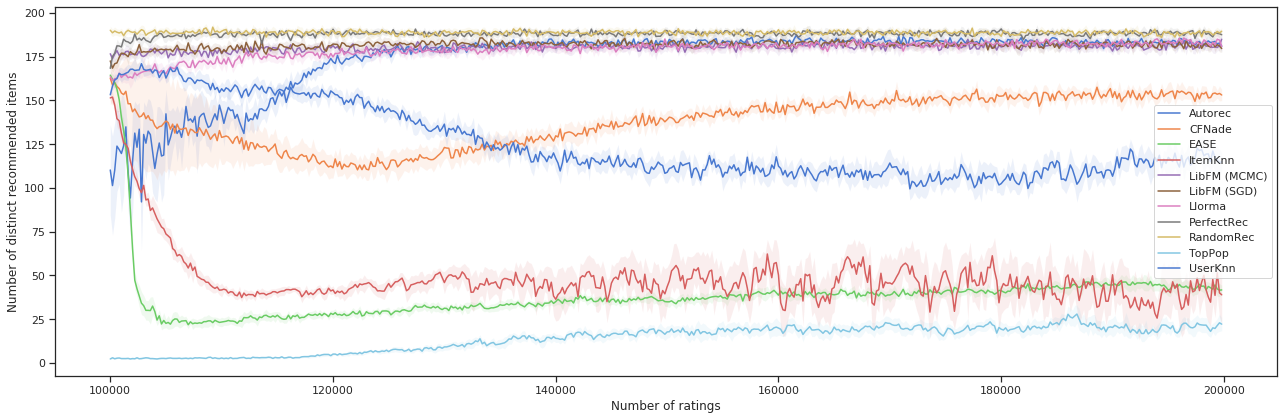

In [509]:
res = plot_coverage_s3(rec_names, 500, 'recsys-eval', 'master', 
                 'topics_dynamic', np.arange(9), 100000
                )

In [ ]:
res = plot_novelty_s3('recsys-eval', data_dir='master', 
                env_name='latent_static', rec_names=rec_names, seeds=np.arange(10),
                num_init_ratings=100000, labels=rec_names)

# Targetted rating investigation

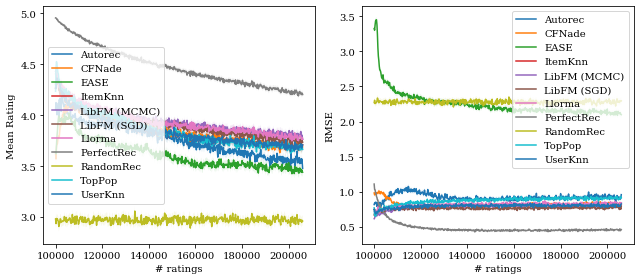

In [432]:
res = plot_ratings_mses_s3(rec_names, 531, 'recsys-eval', 'master', 'latent_static', np.arange(10), plot_dense=False, num_users=1000, rating_frequency=0.2,
                           num_init_ratings=100000)

In [472]:
env_name = 'latent_static'
rec_names = ['Autorec', 'CFNade', 'EASE', 'ItemKnn', 'LibFM (MCMC)', 'LibFM (SGD)',
             'Llorma', 'PerfectRec', 'RandomRec', 'TopPop', 'UserKnn']
plot_names = ['AutoRec', 'CF-NADE', 'EASE', 'ItemKnn', 'Bayes MF', 'SGD MF',
              'LLORMA', 'Oracle', 'Random', 'TopPop', 'UserKnn']
trials = [i for i in range(10)]
means = []
stds = []
for rec_name in rec_names:
    rec_means = compute_across_trials_s3(bucket,
                                         data_dir,
                                         env_name,
                                         [rec_name],
                                         trials,
                                         mean,
                                         load_dense=False)
    stds.append(np.std(rec_means) / np.sqrt(len(trials) - 1))
    means.append(np.mean(rec_means))

In [ ]:
# get stds from mean ratings above
# get stds for coverage means from across 10 seeds? or across the 531 timesteps? or both?
# fix plot and graph

In [514]:
coverages = get_coverage_s3(rec_names, 531, 'recsys-eval', 'master', 'latent_static', np.arange(10), 100000)
coverage_means = np.array(coverages).mean(axis=1)
coverage_stds = np.array(coverages).std(axis=1) / np.sqrt(10 - 1)

In [518]:
plt.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman')

bigfont = 18
medfont = 14
smallfont = 12
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set_palette("muted")

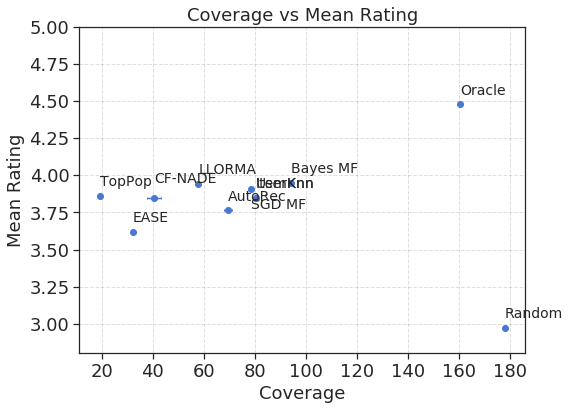

In [520]:
plt.figure(figsize=(8,6))
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.errorbar(coverage_means, means, xerr=coverage_stds * 2, yerr=np.array(stds) * 2, linestyle='None', fmt='o', linewidth=1.4, capsize=1.4)
plt.xlabel("Coverage", fontsize=bigfont)
plt.ylabel("Mean Rating", fontsize=bigfont)
plt.ylim(bottom=2.8, top=5.0)
for i, rec_name in enumerate(plot_names):
    if rec_name == 'LLORMA':
        plt.annotate(rec_name, (coverage_means[i]- 0.017, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'CF-NADE':
        plt.annotate(rec_name, (coverage_means[i] - 0.02, means[i] + 0.1), fontsize=medfont)
    elif rec_name == 'LibFM (SGD)':
        plt.annotate(rec_name, (coverage_means[i] - 0.04, means[i] - 0.13), fontsize=medfont)
    elif rec_name == 'LibFM (MCMC)':
        plt.annotate(rec_name, (coverage_means[i] - 0.04, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'EASE':
        plt.annotate(rec_name, (coverage_means[i] - 0.01, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'SGD MF':
        plt.annotate(rec_name, (coverage_means[i] - 0.02, means[i] - 0.13), fontsize=medfont)
    elif rec_name == 'Bayes MF':
        plt.annotate(rec_name, (coverage_means[i] - 0.023, means[i] + 0.065), fontsize=medfont)
    else:
        plt.annotate(rec_name, (coverage_means[i] - 0.015, means[i] + 0.065), fontsize=medfont)

plt.title("Coverage vs Mean Rating", fontsize=bigfont, fontname='Times New Roman')
plt.savefig('main-plot.pdf')

In [6]:
# S3 storage parameters
bucket_name = 'recsys-eval'
data_dir = 'master'

env_name = 'topics_static'
rec_name = 'PerfectRec'

seed = 0

bucket = boto3.resource('s3').Bucket(bucket_name)
dir_name = s3_experiment_dir_name(data_dir, env_name, rec_name, seed)

res = s3_load_trial(bucket, dir_name, load_dense=True)
rec_hyperparameters, ratings, predictions, dense_ratings, dense_predictions, env_snapshots = res

In [14]:
dense_predictions.shape

(500, 1700000)

In [18]:
ratings = ratings[np.newaxis, np.newaxis, :, :]
predictions = predictions[np.newaxis, np.newaxis, :, :]
dense_ratings = dense_ratings[np.newaxis, np.newaxis, :, :]
dense_predictions = dense_predictions[np.newaxis, np.newaxis, :, :]

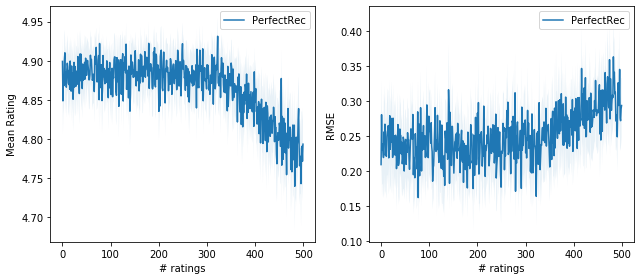

In [28]:
plot_ratings_mses(ratings,
                      np.clip(predictions, 1, 5),
                      [rec_name])

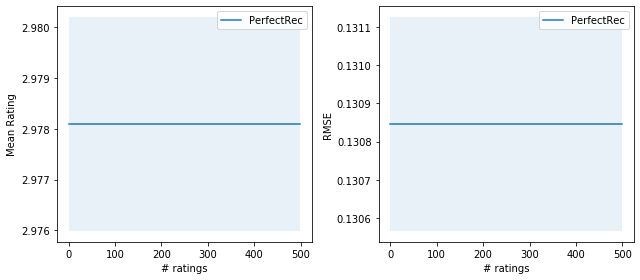

In [21]:
plot_ratings_mses(dense_ratings,
                      dense_predictions,
                      [rec_name])

(array([89524500., 87268000., 84615500., 83790000., 86334000., 85959500.,
        80444500., 82568000., 83908000., 85588000.]),
 array([0.50036225, 1.000315  , 1.50026775, 2.0002205 , 2.50017325,
        3.000126  , 3.50007875, 4.00003151, 4.49998426, 4.99993701,
        5.49988976]),
 <a list of 10 Patch objects>)

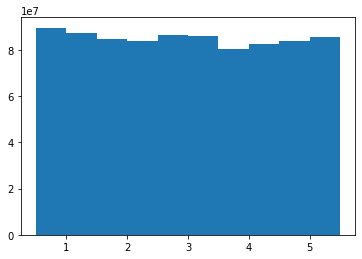

In [23]:
plt.figure()
plt.hist(dense_predictions.flatten())

(array([   58.,   176.,   461.,   793.,  2404.,  3884.,  7128., 14782.,
        26378., 43936.]),
 array([3.7026507 , 3.88237461, 4.06209852, 4.24182242, 4.42154633,
        4.60127023, 4.78099414, 4.96071804, 5.14044195, 5.32016585,
        5.49988976]),
 <a list of 10 Patch objects>)

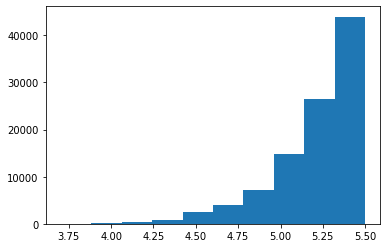

In [24]:
plt.figure()
plt.hist(predictions.flatten())

(array([1.0000e+00, 6.0000e+00, 1.5000e+01, 7.4000e+01, 2.9200e+02,
        8.2400e+02, 2.2500e+03, 5.1770e+03, 9.8550e+03, 8.1506e+04]),
 array([2.18677833, 2.46810049, 2.74942266, 3.03074483, 3.312067  ,
        3.59338916, 3.87471133, 4.1560335 , 4.43735567, 4.71867783,
        5.        ]),
 <a list of 10 Patch objects>)

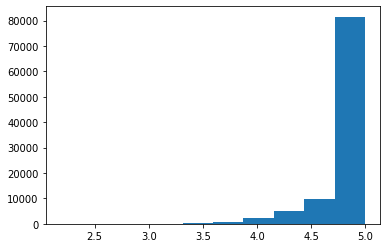

In [25]:
plt.figure()
plt.hist(ratings.flatten())